In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
import optuna



In [2]:
df_tr = pd.read_csv('/Users/dmitrybertnikov/Desktop/ds_learn/work_on_datasets/data/raw/train.csv')
df_tr.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [3]:
df = df_tr.drop(columns='id')

In [4]:
df.head().T

,0,1,2,3,4
road_type,urban,urban,rural,highway,rural
num_lanes,2,4,4,4,1
curvature,0.06,0.99,0.63,0.07,0.58
speed_limit,35,35,70,35,60
lighting,daylight,daylight,dim,dim,daylight
weather,rainy,clear,clear,rainy,foggy
road_signs_present,False,True,False,True,False
public_road,True,False,True,True,False
time_of_day,afternoon,evening,morning,morning,evening
holiday,False,True,True,False,True


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               517754 non-null  object 
 1   num_lanes               517754 non-null  int64  
 2   curvature               517754 non-null  float64
 3   speed_limit             517754 non-null  int64  
 4   lighting                517754 non-null  object 
 5   weather                 517754 non-null  object 
 6   road_signs_present      517754 non-null  bool   
 7   public_road             517754 non-null  bool   
 8   time_of_day             517754 non-null  object 
 9   holiday                 517754 non-null  bool   
 10  school_season           517754 non-null  bool   
 11  num_reported_accidents  517754 non-null  int64  
 12  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(2), int64(3), object(4)
memory usage: 37.5+ MB


In [6]:
df.isna().sum()

road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64

In [7]:
X = df.drop(columns='accident_risk')
y = df['accident_risk']

In [8]:
cat_features = X.select_dtypes(include='object').columns.tolist()
cat_features
cat_features_indices = [i for i, col in enumerate(X.columns) if col in cat_features]
cat_features_indices

[0, 4, 5, 8]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.25, random_state=42)



In [10]:
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd

def train_models(X_train, X_test, y_train, y_test, cat_features=None, cv_folds=5):
    """
    Обучает несколько моделей и выбирает лучшую по R²
    """
    
    # Автоматически определяем категориальные признаки, если не указаны
    if cat_features is None:
        cat_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
        print(f"📋 Автоопределены категориальные признаки: {cat_features}")
    
    # Получаем индексы категориальных признаков для CatBoost
    cat_features_indices = [i for i, col in enumerate(X_train.columns) if col in cat_features]
    
    print(f"🎯 Категориальные признаки ({len(cat_features_indices)}): {cat_features_indices}")
    
    models = {
        'CatBoost': CatBoostRegressor(
            cat_features=cat_features_indices,
            verbose=False, 
            random_state=42,
            n_estimators=100
        ),
        'RandomForest': RandomForestRegressor(
            n_estimators=100, 
            random_state=42, 
            n_jobs=-1
        ),
        'GradientBoosting': GradientBoostingRegressor(
            n_estimators=100, 
            random_state=42
        ),
    }
    
    results = []  
    best_score = -np.inf
    best_model = None
    best_model_name = ""
    
    print("\n=== СРАВНЕНИЕ МОДЕЛЕЙ ===")
    print("Модель           | CV R²     | Train R²  | Test R²   | Status")
    print("-" * 55)
    
    for name, model in models.items():
        try:
            # Для моделей кроме CatBoost нужно предварительно закодировать категориальные признаки
            if name != 'CatBoost' and cat_features:
                X_train_encoded = X_train.copy()
                X_test_encoded = X_test.copy()
                
                # Кодируем категориальные признаки
                for feature in cat_features:
                    if feature in X_train_encoded.columns:
                        X_train_encoded[feature] = X_train_encoded[feature].astype('category').cat.codes
                        X_test_encoded[feature] = X_test_encoded[feature].astype('category').cat.codes
                
                X_train_to_use = X_train_encoded
                X_test_to_use = X_test_encoded
            else:
                X_train_to_use = X_train
                X_test_to_use = X_test
            
            # Кросс-валидация
            cv_scores = cross_val_score(model, X_train_to_use, y_train, cv=cv_folds, scoring='r2')
            cv_r2 = cv_scores.mean()
            
            # Обучение
            model.fit(X_train_to_use, y_train)
            
            # Предсказания
            y_train_pred = model.predict(X_train_to_use)
            y_test_pred = model.predict(X_test_to_use)
            
            # Метрики
            train_r2 = r2_score(y_train, y_train_pred)
            test_r2 = r2_score(y_test, y_test_pred)
            
            # Сохраняем результаты 
            results.append({
                'Model': name,
                'CV_R2': cv_r2,
                'Train_R2': train_r2,
                'Test_R2': test_r2,  
                'CV_Std': cv_scores.std(),
                'Model_Object': model
            })
            
            # Проверяем на лучшую модель
            if test_r2 > best_score:
                best_score = test_r2
                best_model = model
                best_model_name = name
            
            print(f"{name:15} | {cv_r2:8.4f}  | {train_r2:8.4f}  | {test_r2:8.4f}  | ✅")
            
        except Exception as e:
            print(f"{name:15} | {'-':8}  | {'-':8}  | {'-':8}  | ❌ {str(e)[:20]}...")
            continue
    
    # Создаем DataFrame 
    if results:  # Проверяем, что есть результаты
        results_df = pd.DataFrame(results)
        
        # Сортируем по Test R² 
        results_df = results_df.sort_values('Test_R2', ascending=False).reset_index(drop=True)
        
        print("\n" + "="*55)
        print(f"🎯 ЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
        print(f"📊 Test R²: {best_score:.4f}")
        print("="*55)
        
        return best_model, best_model_name, results_df
    else:
        print("❌ Ни одна модель не была успешно обучена")
        return None, None, None

# Упрощенная версия для быстрого тестирования
def train_models_simple(X_train, X_test, y_train, y_test, cv_folds=5):
    """
    Упрощенная версия без категориальных признаков
    """
    models = {
        'CatBoost': CatBoostRegressor(verbose=False, random_state=42, n_estimators=100),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
        'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    }
    
    results = []
    best_score = -np.inf
    best_model = None
    best_model_name = ""
    
    print("=== СРАВНЕНИЕ МОДЕЛЕЙ ===")
    print("Модель           | CV R²     | Train R²  | Test R²   | Status")
    print("-" * 55)
    
    for name, model in models.items():
        try:
            # Кросс-валидация
            cv_scores = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring='r2')
            cv_r2 = cv_scores.mean()
            
            # Обучение
            model.fit(X_train, y_train)
            
            # Предсказания
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
            
            # Метрики
            train_r2 = r2_score(y_train, y_train_pred)
            test_r2 = r2_score(y_test, y_test_pred)
            
            results.append({
                'Model': name,
                'CV_R2': cv_r2,
                'Train_R2': train_r2,
                'Test_R2': test_r2,
                'CV_Std': cv_scores.std(),
                'Model_Object': model
            })
            
            if test_r2 > best_score:
                best_score = test_r2
                best_model = model
                best_model_name = name
            
            print(f"{name:15} | {cv_r2:8.4f}  | {train_r2:8.4f}  | {test_r2:8.4f}  | ✅")
            
        except Exception as e:
            print(f"{name:15} | {'-':8}  | {'-':8}  | {'-':8}  | ❌ {str(e)[:20]}...")
            continue
    
    if results:
        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values('Test_R2', ascending=False).reset_index(drop=True)
        
        print("\n" + "="*55)
        print(f"🎯 ЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
        print(f"📊 Test R²: {best_score:.4f}")
        print("="*55)
        
        return best_model, best_model_name, results_df
    else:
        print("❌ Ни одна модель не была успешно обучена")
        return None, None, None

# Проверка данных перед обучением
def check_data(X_train, X_test, y_train, y_test):
    """
    Проверка корректности данных перед обучением
    """
    print("=== ПРОВЕРКА ДАННЫХ ===")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")
    
    print(f"\nТипы данных в X_train:")
    print(X_train.dtypes)
    
    print(f"\nПропущенные значения:")
    print(f"X_train: {X_train.isnull().sum().sum()}")
    print(f"X_test: {X_test.isnull().sum().sum()}")
    print(f"y_train: {y_train.isnull().sum()}")
    print(f"y_test: {y_test.isnull().sum()}")
    
    # Проверяем, есть ли категориальные признаки
    cat_features = X_train.select_dtypes(include=['object', 'category']).columns
    if len(cat_features) > 0:
        print(f"\n📋 Найдены категориальные признаки: {list(cat_features)}")
        return list(cat_features)
    else:
        print(f"\n✅ Все признаки числовые")
        return None

# Полный процесс с проверкой
def full_training_pipeline(X_train, X_test, y_train, y_test):
    """
    Полный пайплайн обучения с проверкой данных
    """
    # 1. Проверяем данные
    cat_features = check_data(X_train, X_test, y_train, y_test)
    
    # 2. Обучаем модели
    if cat_features:
        print(f"\n🎯 Обучаем с учетом категориальных признаков...")
        best_model, best_name, results_df = train_models(
            X_train, X_test, y_train, y_test, cat_features=cat_features
        )
    else:
        print(f"\n🎯 Обучаем модели...")
        best_model, best_name, results_df = train_models_simple(
            X_train, X_test, y_train, y_test
        )
    
    return best_model, best_name, results_df

# Запуск
print("Запуск исправленной функции...")
best_model, best_name, results_df = full_training_pipeline(X_train, X_test, y_train, y_test)

if results_df is not None:
    print(f"\n📊 Финальные результаты:")
    print(results_df[['Model', 'CV_R2', 'Train_R2', 'Test_R2']].round(4))
else:
    print("❌ Обучение не удалось")

Запуск исправленной функции...
=== ПРОВЕРКА ДАННЫХ ===
X_train shape: (388315, 12)
X_test shape: (129439, 12)
y_train shape: (388315,)
y_test shape: (129439,)

Типы данных в X_train:
road_type                  object
num_lanes                   int64
curvature                 float64
speed_limit                 int64
lighting                   object
weather                    object
road_signs_present           bool
public_road                  bool
time_of_day                object
holiday                      bool
school_season                bool
num_reported_accidents      int64
dtype: object

Пропущенные значения:
X_train: 0
X_test: 0
y_train: 0
y_test: 0

📋 Найдены категориальные признаки: ['road_type', 'lighting', 'weather', 'time_of_day']

🎯 Обучаем с учетом категориальных признаков...
🎯 Категориальные признаки (4): [0, 4, 5, 8]

=== СРАВНЕНИЕ МОДЕЛЕЙ ===
Модель           | CV R²     | Train R²  | Test R²   | Status
-------------------------------------------------------
CatBo

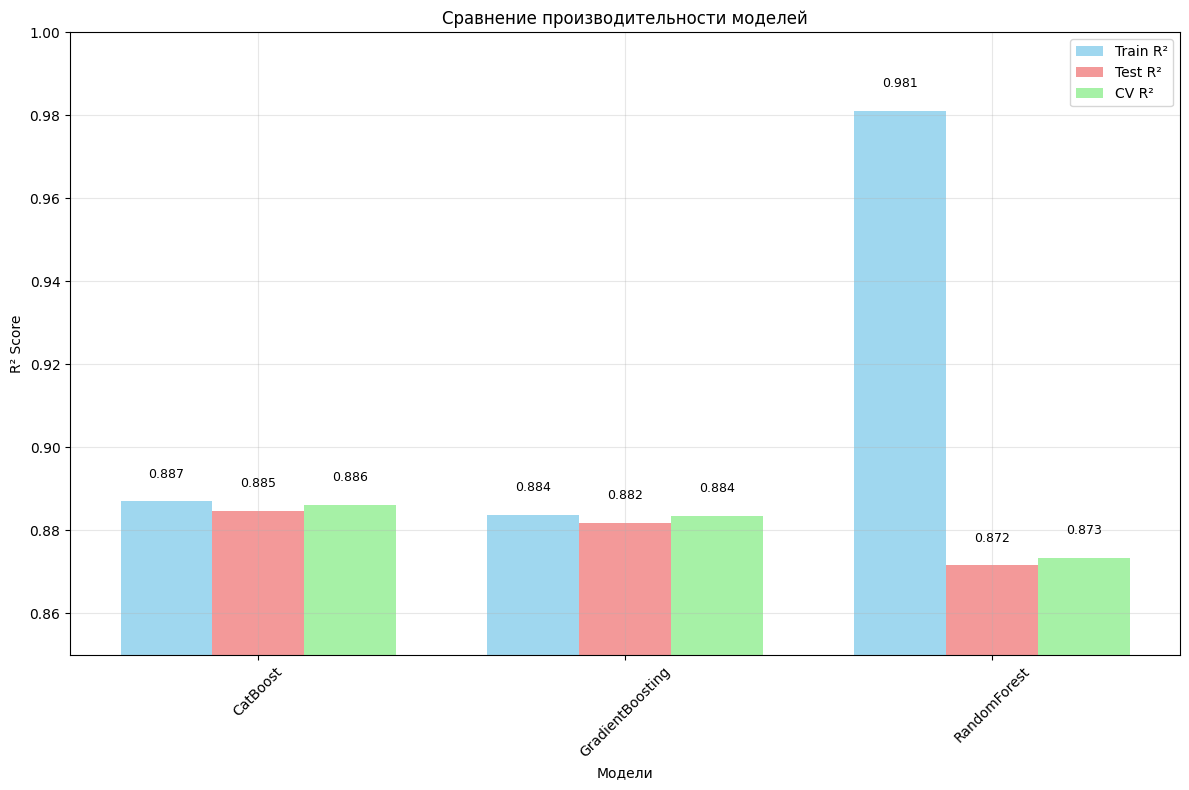

In [12]:
# Данные из ваших результатов
models = ['CatBoost', 'GradientBoosting', 'RandomForest']
train_scores = [0.8870, 0.8837, 0.9811]
test_scores = [0.8847, 0.8819, 0.8716]
cv_scores = [0.8861, 0.8836, 0.8734]

# Создаем DataFrame для удобства
results_df = pd.DataFrame({
    'Model': models,
    'Train_R2': train_scores,
    'Test_R2': test_scores,
    'CV_R2': cv_scores
})

# Визуализация
plt.figure(figsize=(12, 8))

# Bar plot сравнение моделей
x = np.arange(len(models))
width = 0.25

plt.bar(x - width, train_scores, width, label='Train R²', alpha=0.8, color='skyblue')
plt.bar(x, test_scores, width, label='Test R²', alpha=0.8, color='lightcoral')
plt.bar(x + width, cv_scores, width, label='CV R²', alpha=0.8, color='lightgreen')

plt.xlabel('Модели')
plt.ylabel('R² Score')
plt.title('Сравнение производительности моделей')
plt.xticks(x, models, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0.85, 1.0)

# Добавляем значения на столбцы
for i, (train, test, cv) in enumerate(zip(train_scores, test_scores, cv_scores)):
    plt.text(i - width, train + 0.005, f'{train:.3f}', ha='center', va='bottom', fontsize=9)
    plt.text(i, test + 0.005, f'{test:.3f}', ha='center', va='bottom', fontsize=9)
    plt.text(i + width, cv + 0.005, f'{cv:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

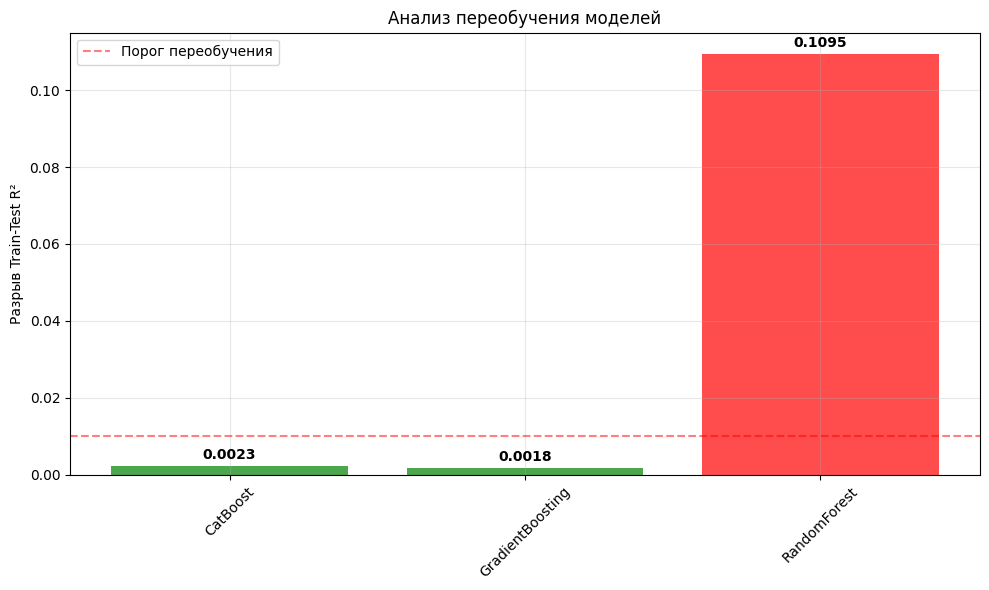

In [13]:
# Визуализация переобучения
plt.figure(figsize=(10, 6))

overfitting_gap = [train - test for train, test in zip(train_scores, test_scores)]
colors = ['green' if gap < 0.01 else 'orange' if gap < 0.05 else 'red' for gap in overfitting_gap]

bars = plt.bar(models, overfitting_gap, color=colors, alpha=0.7)
plt.ylabel('Разрыв Train-Test R²')
plt.title('Анализ переобучения моделей')
plt.axhline(y=0.01, color='red', linestyle='--', alpha=0.5, label='Порог переобучения')

# Добавляем значения
for bar, gap in zip(bars, overfitting_gap):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{gap:.4f}', ha='center', va='bottom', fontweight='bold')

plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# TODO Доделать оптимизацию через оптуну
# def objective_catboost(trial):
#     max_depth = 4 #trial.suggest_int("max_depth", 3, 5)
#     learning_rate = trial.suggest_float("learning_rate", 1e-5, 1, log=True)
#     n_estimators = trial.suggest_int("n_estimators", 1200, 2000)
    

#     model = CatBoostRegressor(
#         cat_features=cat_features_indices,
#         max_depth=max_depth,
#         learning_rate=learning_rate,
#         n_estimators=n_estimators)

    

#     score = cross_val_score(model, X, y, cv=3, scoring="r2", n_jobs=-1).mean()
#     return score

# study = optuna.create_study(direction="maximize")
# study.optimize(objective_catboost, n_trials=30)

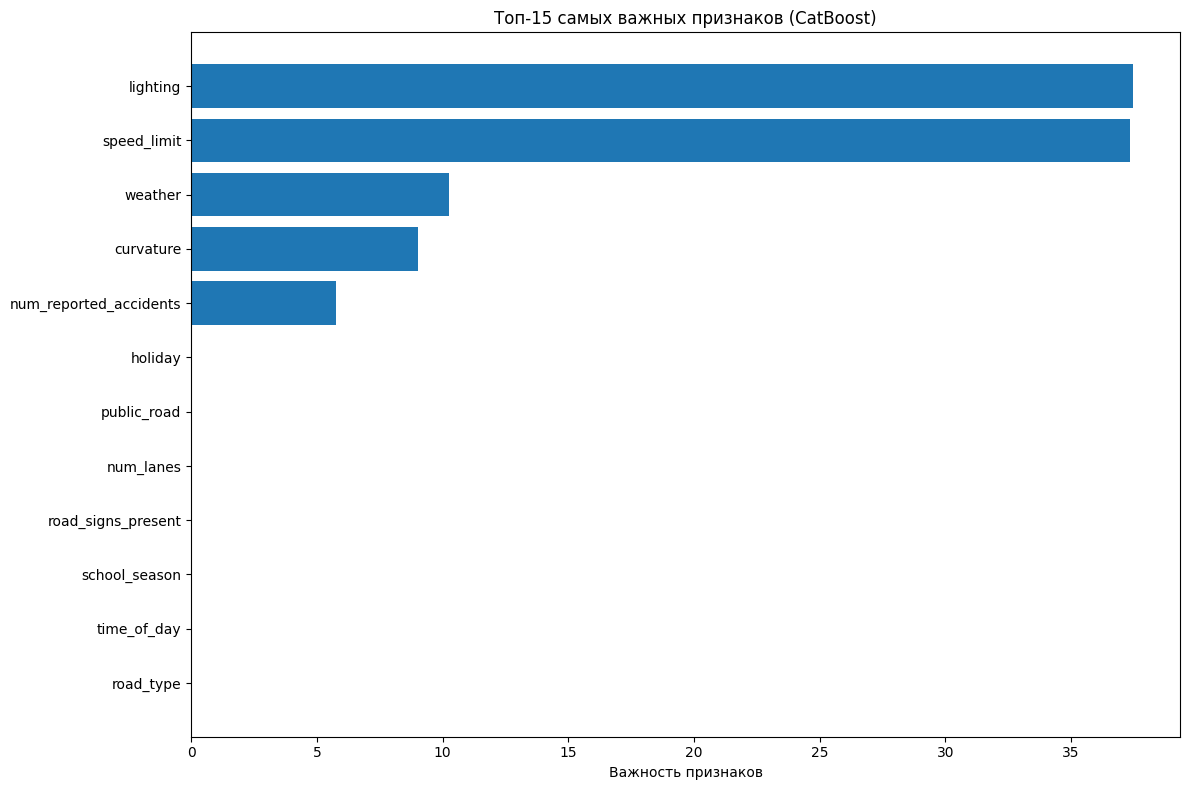

In [17]:
# Важность признаков
feature_importance = best_model.get_feature_importance()
feature_names = X_train.columns
    
# Сортируем по важности
indices = np.argsort(feature_importance)[::-1]
    
# Топ-15 признаков
top_n = min(15, len(feature_names))
    
plt.figure(figsize=(12, 8))
plt.barh(range(top_n), feature_importance[indices][:top_n][::-1])
plt.yticks(range(top_n), [feature_names[i] for i in indices[:top_n]][::-1])
plt.xlabel('Важность признаков')
plt.title('Топ-15 самых важных признаков (CatBoost)')
plt.tight_layout()
plt.show()

In [18]:
# Красивая таблица с результатами
from tabulate import tabulate

table_data = []
for i, model in enumerate(models):
    table_data.append([
        model,
        f"{train_scores[i]:.4f}",
        f"{test_scores[i]:.4f}", 
        f"{cv_scores[i]:.4f}",
        f"{overfitting_gap[i]:.4f}",
        "✅ Лучшая" if i == 0 else "✅ Хорошая" if i == 1 else "⚠️ Переобучение"
    ])

headers = ["Модель", "Train R²", "Test R²", "CV R²", "Overfitting Gap", "Статус"]

print("📊 ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ BASELINE")
print("="*80)
print(tabulate(table_data, headers=headers, tablefmt="grid", stralign="center"))

📊 ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ BASELINE
+------------------+------------+-----------+---------+-------------------+-----------------+
|      Модель      |   Train R² |   Test R² |   CV R² |   Overfitting Gap |     Статус      |
+==================+============+===========+=========+===================+=================+
|     CatBoost     |     0.887  |    0.8847 |  0.8861 |            0.0023 |    ✅ Лучшая    |
+------------------+------------+-----------+---------+-------------------+-----------------+
| GradientBoosting |     0.8837 |    0.8819 |  0.8836 |            0.0018 |   ✅ Хорошая    |
+------------------+------------+-----------+---------+-------------------+-----------------+
|   RandomForest   |     0.9811 |    0.8716 |  0.8734 |            0.1095 | ⚠️ Переобучение |
+------------------+------------+-----------+---------+-------------------+-----------------+


In [19]:
df_test = pd.read_csv('/Users/dmitrybertnikov/Desktop/ds_learn/work_on_datasets/data/raw/test.csv')
df_test.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1
1,517755,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0
2,517756,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1
3,517757,rural,4,0.95,35,daylight,rainy,False,False,afternoon,False,False,2
4,517758,highway,2,0.86,35,daylight,clear,True,False,evening,False,True,3
